### ENV Setup

In [14]:
!pip install catboost optuna


  Using cached catboost-1.2.8-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached optuna-4.3.0-py3-none-any.whl.metadata (17 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached plotly-6.0.1-py3-none-any.whl.metadata (6.7 kB)
  Using cached alembic-1.15.2-py3-none-any.whl.metadata (7.3 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached mako-1.3.10-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
Using cached catboost-1.2.8-cp311-cp311-manylinux2014_x86_64.whl (99.2 MB)
Using cached optuna-4.3.0-py3-none-any.whl (386 kB)
Using cached alembic-1.15.2-py3-none-any.whl (231 kB)
Using cached colorlog-6.9.0-py3-none-any.whl (11 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)
Using cached plotly-6.0.1-py3-none-any.whl (14.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.0/331.0 kB 3.6 MB/s eta 0:00:00a 0:00:01
Using cached typing_extension

In [15]:
!pip install matplotlib_venn

  Using cached matplotlib_venn-1.1.2-py3-none-any.whl


### Experiments

In [1]:
import pandas as pd
combined_df = pd.read_csv("all_features_combined_ru_uk_holdout.csv")

In [2]:
combined_df['label'] = combined_df['revision_is_identity_reverted']
combined_df['label'].value_counts()

label
0    2812354
1     360252
Name: count, dtype: int64

In [5]:
base_features = [
    'wiki_db',
    'event_comment',
    'event_user_text_historical',
    'event_user_seconds_since_previous_revision',
    'page_revision_count',
    'revision_text_bytes_diff',
    'event_timestamp',
    'revision_parent_id',
    'is_mobile_edit',
    'is_mobile_web_edit',
    'is_visualeditor',
    'is_wikieditor',
    'is_mobile_app_edit',
    'is_android_app_edit',
    'is_ios_app_edit',
    'user',
    'event_date',
]


In [6]:
experiment1_features = base_features + [
    col for col in combined_df.columns if col.startswith("vandalism_")
] + [
    col for col in combined_df.columns if col.startswith("manip_")
]

In [7]:
experiment2_features = base_features + [
    col for col in combined_df.columns if col.startswith("vandalism_")
]

In [8]:
vandalism_features = [col for col in combined_df.columns if col.startswith("vandalism_")]
manipulation_features = [col for col in combined_df.columns if col.startswith("manip_")]

target = 'label'

In [9]:
combined_df.head()

,Unnamed: 0,wiki_db,event_comment,event_user_text_historical,event_user_seconds_since_previous_revision,revision_id,page_title,page_revision_count,revision_text_bytes_diff,revision_is_identity_reverted,...,manip_remove_max_prob_1,manip_change_mean_logit_0,manip_change_mean_logit_1,manip_change_max_logit_0,manip_change_max_logit_1,manip_change_mean_prob_0,manip_change_mean_prob_1,manip_change_max_prob_0,manip_change_max_prob_1,label
0,662,ruwiki,/* Биография */,178.66.131.56,NaN,125797477,"Столбун,_Сергей_Николаевич",5,0.0,0,...,0.708624,-0.054130,0.217185,-0.054130,0.217185,0.432584,0.567416,0.432584,0.567416,0
1,663,ruwiki,[[ВП:Откат|откат]] правок [[Special:Contribs/8...,Lesless,1609.0,125799865,Газлайтинг,246,-105.0,0,...,0.522578,-0.459380,0.429330,-0.459380,0.429330,0.291376,0.708624,0.291376,0.708624,0
2,667,ruwiki,NaN,Роман Сергеевич Сидоров,244.0,125824728,Всеобщая_забастовка_в_Швеции_(1909),10,393.0,0,...,0.708624,-0.078635,0.272158,-0.078635,0.272158,0.413190,0.586810,0.413190,0.586810,0
3,668,ruwiki,NaN,NaN,NaN,125835375,Убийство_Дарьи_Дугиной,564,-22.0,0,...,0.708624,-0.126425,0.060442,-0.126425,0.060442,0.453419,0.546581,0.453419,0.546581,0
4,673,ruwiki,[[ВП:Откат|откат]] правок [[Special:Contribs/8...,EstherColeman,194.0,125857872,5_октября,567,-175.0,0,...,0.621957,-0.459380,0.429330,-0.459380,0.429330,0.291376,0.708624,0.291376,0.708624,0


In [5]:
combined_df = combined_df.sort_values(['page_title', 'event_timestamp'])

combined_df['reverts_so_far'] = (
    combined_df.groupby('page_title')['label']
    .cumsum()
    .shift(fill_value=0)
)

combined_df['page_revert_rate'] = combined_df['reverts_so_far'] / combined_df['page_revision_count']

In [6]:
print(combined_df['page_revert_rate'].describe())


count    3.172604e+06
mean     1.896288e-02
std      3.207992e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.412969e-03
max      3.694000e+02
Name: page_revert_rate, dtype: float64


In [7]:
combined_df = combined_df[(combined_df['page_revert_rate'].isna()) | (combined_df['page_revert_rate'] <= 1)]
print(len(combined_df))

3167412


In [9]:
combined_df['label'].value_counts()

label
0    2807453
1     359959
Name: count, dtype: int64

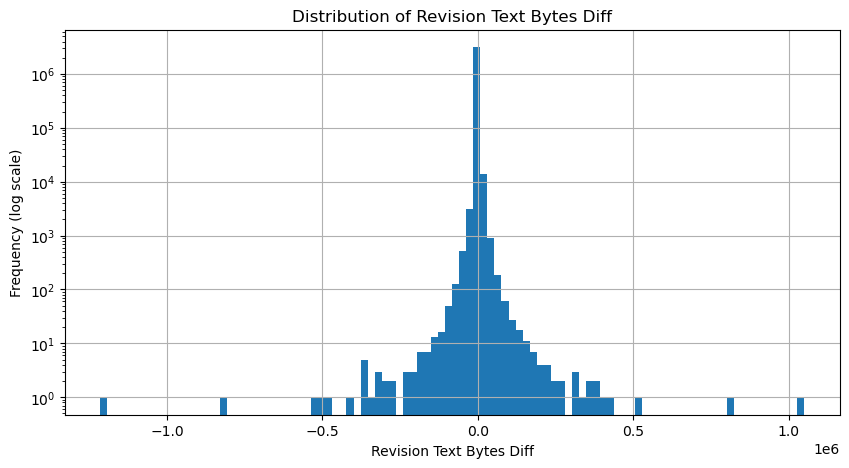

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
combined_df['revision_text_bytes_diff'].dropna().hist(bins=100)
plt.yscale('log')
plt.xlabel('Revision Text Bytes Diff')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Revision Text Bytes Diff')
plt.grid(True)
plt.show()


In [11]:
q1 = combined_df['revision_text_bytes_diff'].quantile(0.25)
q3 = combined_df['revision_text_bytes_diff'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

combined_df = combined_df[combined_df['revision_text_bytes_diff'].abs() < upper_bound]

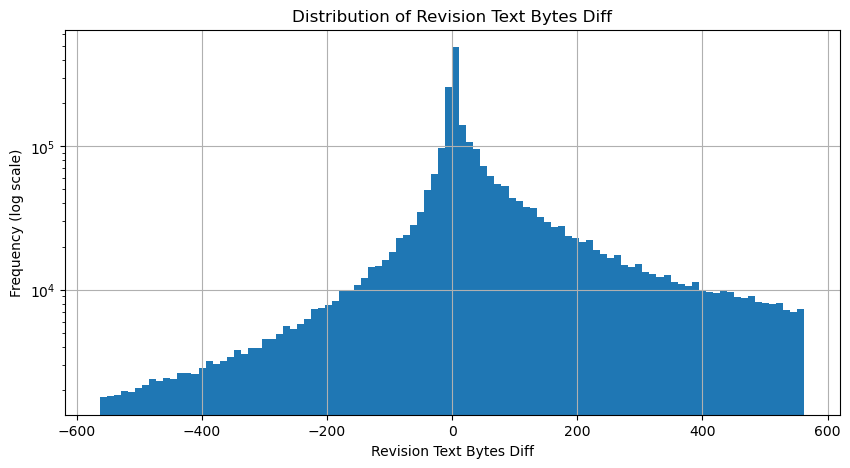

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
combined_df['revision_text_bytes_diff'].dropna().hist(bins=100)
plt.yscale('log')
plt.xlabel('Revision Text Bytes Diff')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Revision Text Bytes Diff')
plt.grid(True)
plt.show()


In [27]:
X_full_model2 = df[features_exp2].copy()
X_full_model2[cat_features] = X_full_model2[cat_features].fillna("nan").astype(str)

full_pool_model2 = Pool(X_full_model2, cat_features=cat_features)


df["model2_prediction_proba"] = model2.predict_proba(full_pool_model2)[:, 1]
df["model2_prediction_label"] = model2.predict(full_pool_model2)
df.to_csv("dataset_with_both_model_predictions.csv", index=False)

In [21]:
df

,Unnamed: 0,wiki_db,event_comment,event_user_text_historical,event_user_seconds_since_previous_revision,revision_id,page_title,page_revision_count,revision_text_bytes_diff,revision_is_identity_reverted,...,manip_change_mean_prob_1,manip_change_max_prob_0,manip_change_max_prob_1,label,reverts_so_far,page_revert_rate,prediction_proba,prediction_label,model2_prediction_proba,model2_prediction_label
2761504,1533410,ukwiki,NaN,Slaktingar2,102.0,40506451,!!!,35,6.0,0,...,0.517682,0.482318,0.517682,0,1.0,0.028571,0.480550,0,0.456543,0
1289383,4614755,ruwiki,NaN,Пушёк,2028.0,128445272,!!_(значения),28,-96.0,0,...,0.708624,0.291376,0.708624,0,0.0,0.000000,0.662994,1,0.657590,1
1452734,5201450,ruwiki,NaN,Пушёк,21.0,128445278,!?,10,-114.0,0,...,0.708624,0.291376,0.708624,0,0.0,0.000000,0.601944,1,0.583325,1
1286652,4605056,ruwiki,/* Дискография */ обновление,Yxag,296.0,129159178,!T.O.O.H.!,45,182.0,0,...,0.532795,0.467204,0.532795,0,0.0,0.000000,0.339571,0,0.311975,0
1401808,5020103,ruwiki,"/* Состав */ оформление, обновление",Yxag,229.0,129159209,!T.O.O.H.!,46,276.0,0,...,0.581141,0.418859,0.581141,0,0.0,0.000000,0.598244,1,0.539962,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583118,5666977,ruwiki,[[ВП:Откат|откат]] правок [[Special:Contribs/М...,Lesless,1941.0,133161327,Ꚕ,17,-6.0,0,...,0.708624,0.291376,0.708624,0,2.0,0.117647,0.720087,1,0.707477,1
798344,2856646,ruwiki,NaN,Person or Persons Unknown,317.0,130503896,Ꞑ,17,-37.0,0,...,0.548505,0.451495,0.548505,0,2.0,0.117647,0.470061,0,0.435903,0
699169,2502228,ruwiki,оформление по [[ВП:Н]],Bezik,130.0,126321929,NaN,75,-98.0,0,...,0.562402,0.437598,0.562402,0,0.0,0.000000,0.847698,1,0.875749,1
1813062,6491597,ruwiki,NaN,91.127.38.12,NaN,130847203,NaN,76,-65.0,1,...,0.708624,0.291376,0.708624,1,NaN,NaN,0.720534,1,0.672818,1


In [31]:
ru_uk_titles = pd.read_csv("ru_to_uk_mapping.csv")
ru_uk_titles.columns

Index(['ru_title', 'uk_title'], dtype='object')

In [ ]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report


def run_experiment(features, name):
    print(f"\nRunning {name}...")

    df_bal = df[features + ['label', 'event_timestamp']].copy()
    print(df.columns[df.columns.duplicated()])

    df_bal = df_bal.loc[:, ~df_bal.columns.duplicated()]

    df_bal['event_timestamp'] = pd.to_datetime(df_bal['event_timestamp'])

    # Manual balance
    df_minority = df_bal[df_bal.label == 1]
    df_majority = df_bal[df_bal.label == 0].sample(n=len(df_minority), random_state=42)
    df_balanced = pd.concat([df_minority, df_majority]).sample(frac=1, random_state=42)

    # Sort by timestamp
    df_balanced = df_balanced.sort_values('event_timestamp').reset_index(drop=True)

    # 60% train
    # 20% validation
    # 20% test
    total_len = len(df_balanced)
    test_size = int(0.2 * total_len)
    valid_size = int(0.2 * total_len)

    df_test = df_balanced.iloc[-test_size:]
    df_valid = df_balanced.iloc[-(test_size + valid_size):-test_size]
    df_train = df_balanced.iloc[:-(test_size + valid_size)]

    print(f"Train set: {len(df_train)} records")
    print(f"Validation set: {len(df_valid)} records")
    print(f"Test set: {len(df_test)} records")

    X_train = df_train.drop(columns=['label', 'event_timestamp'])
    y_train = df_train['label']
    X_valid = df_valid.drop(columns=['label', 'event_timestamp'])
    y_valid = df_valid['label']
    X_test = df_test.drop(columns=['label', 'event_timestamp'])
    y_test = df_test['label']

    cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
    for X in [X_train, X_valid, X_test]:
        X[cat_features] = X[cat_features].fillna("nan").astype(str)

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

    def objective(trial):
        params = {
            "iterations": 500,
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "depth": trial.suggest_int("depth", 4, 10),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0),
            "loss_function": "Logloss",
            "eval_metric": "F1",
            "random_seed": 42,
            "early_stopping_rounds": 50,
            "verbose": 100
        }
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=valid_pool, use_best_model=True)
        return model.get_best_score()['validation']['F1']

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30)

    best_params = study.best_params
    best_params.update({
        "iterations": 1000,
        "loss_function": "Logloss",
        "eval_metric": "F1",
        "random_seed": 42,
        "early_stopping_rounds": 50,
        "verbose": 100
    })

    model = CatBoostClassifier(**best_params)
    model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

    preds = model.predict(valid_pool)
    probas = model.predict_proba(valid_pool)[:, 1]
    acc = accuracy_score(y_valid, preds)
    auc = roc_auc_score(y_valid, probas)
    f1 = f1_score(y_valid, preds)

    print(f"\nValidation Metrics for {name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"AUC:      {auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"\nValidation Classification Report:\n")
    print(classification_report(y_valid, preds))

    test_pool = Pool(X_test, y_test, cat_features=cat_features)
    test_preds = model.predict(test_pool)
    test_probas = model.predict_proba(test_pool)[:, 1]
    test_acc = accuracy_score(y_test, test_preds)
    test_auc = roc_auc_score(y_test, test_probas)
    test_f1 = f1_score(y_test, test_preds)

    print(f"\nFinal Evaluation on Test Set for {name}:")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"AUC:      {test_auc:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"\nTest Classification Report:\n")
    print(classification_report(y_test, test_preds))

    return model, study, test_acc, test_auc, test_f1


In [ ]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], errors='coerce')

base_features = [
    'wiki_db',
    'revision_text_bytes_diff',
    'user',
    'event_date',
]


features_exp1 = base_features + vandalism_features + manipulation_features
features_exp2 = base_features + vandalism_features

model1, study1, acc1, auc1, f1_1 = run_experiment(features_exp1, "Experiment 1 (vandalism + manipulation)")
model1.save_model("vandalism_manip.cbm")

model2, study2, acc2, auc2, f1_2 = run_experiment(features_exp2, "Experiment 2 (vandalism only)")
model2.save_model("vandalism.cbm")

### Evaluation on different subsets of data

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,
    classification_report, cohen_kappa_score, brier_score_loss
)

def bootstrap_ci(metric_func, y_true, y_pred, n_bootstrap=1000, alpha=0.05, sample_ratio=0.8):
    scores = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = len(y_true)
    sample_size = int(sample_ratio * n)

    for _ in range(n_bootstrap):
        indices = np.random.choice(n, sample_size, replace=False)
        score = metric_func(y_true[indices], y_pred[indices])
        scores.append(score)

    lower = np.percentile(scores, 100 * alpha / 2)
    upper = np.percentile(scores, 100 * (1 - alpha / 2))
    return np.mean(scores), (lower, upper), scores


def bootstrap_diff_ci(metric_func, y_true, pred_a, pred_b, n_bootstrap=1000, alpha=0.05):
    diffs = []
    y_true = np.array(y_true)
    pred_a = np.array(pred_a)
    pred_b = np.array(pred_b)
    n = len(y_true)

    for _ in range(n_bootstrap):
        idx = np.random.choice(n, n, replace=True)
        score_a = metric_func(y_true[idx], pred_a[idx])
        score_b = metric_func(y_true[idx], pred_b[idx])
        diffs.append(score_a - score_b)

    lower = np.percentile(diffs, 100 * alpha / 2)
    upper = np.percentile(diffs, 100 * (1 - alpha / 2))
    return np.mean(diffs), (lower, upper)

def plot_confidence_intervals(metric_name, scores, mean, ci_low, ci_high):
    # Histogram + KDE
    sns.histplot(scores, kde=True)
    plt.axvline(ci_low, color='red', linestyle='--', label='2.5th Percentile')
    plt.axvline(ci_high, color='red', linestyle='--', label='97.5th Percentile')
    plt.axvline(mean, color='blue', linestyle='-', label='Mean')
    plt.title(f"Bootstrap Distribution for {metric_name}")
    plt.xlabel("Score")
    plt.legend()
    plt.show()

    # Boxplot
    plt.boxplot(scores, vert=False)
    plt.title(f"Boxplot for {metric_name}")
    plt.xlabel("Score")
    plt.show()

def evaluate_subset(name, y_true, y_pred, y_proba, with_ci=True):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    brier = brier_score_loss(y_true, y_proba)

    mask_disagree = y_pred != y_true
    bs_disagree = brier_score_loss(np.array(y_true)[mask_disagree], np.array(y_proba)[mask_disagree]) if np.any(mask_disagree) else np.nan

    print(f"\n{name} Metrics:")
    print(f"   Accuracy:                          {acc:.4f}")
    print(f"   AUC:                               {auc:.4f}")
    print(f"   F1 Score:                          {f1:.4f}")
    print(f"   Precision:                         {prec:.4f}")
    print(f"   Recall:                            {rec:.4f}")
    print(f"   Cohen’s Kappa:                     {kappa:.4f}")
    print(f"   Brier Score:                       {brier:.4f}")
    print(f"   Brier Score (disagreements only): {bs_disagree:.4f}" if not np.isnan(bs_disagree) else "   Brier Score (disagreements only): N/A")

    if with_ci:
        kappa_mean, (kappa_low, kappa_high), kappa_scores = bootstrap_ci(cohen_kappa_score, y_true, y_pred)
        brier_mean, (brier_low, brier_high), brier_scores = bootstrap_ci(brier_score_loss, y_true, y_proba)

        print(f"   Kappa 95% CI:                      [{kappa_low:.4f}, {kappa_high:.4f}]")
        print(f"   Brier Score 95% CI:                [{brier_low:.4f}, {brier_high:.4f}]")

        # Error Bar Chart
        metrics = ['Kappa', 'Brier']
        means = [kappa_mean, brier_mean]
        lowers = [kappa_low, brier_low]
        uppers = [kappa_high, brier_high]
        errors = [[m - l for m, l in zip(means, lowers)],
                  [u - m for m, u in zip(means, uppers)]]

        plt.errorbar(metrics, means, yerr=errors, fmt='o', capsize=5)
        plt.title("95% Confidence Intervals")
        plt.ylabel("Score")
        plt.grid(True)
        plt.show()

        # Bar chart with CI ranges
        ranges = [u - l for l, u in zip(lowers, uppers)]
        plt.barh(metrics, means, xerr=[r / 2 for r in ranges], capsize=5)
        plt.xlabel("Score")
        plt.title("Metric Means with 95% CI")
        plt.grid(True)
        plt.show()

        # Individual distributions
        plot_confidence_intervals("Kappa", kappa_scores, kappa_mean, kappa_low, kappa_high)
        plot_confidence_intervals("Brier Score", brier_scores, brier_mean, brier_low, brier_high)

    print(f"\n Classification Report:\n{classification_report(y_true, y_pred)}")


In [71]:
def evaluate_model_on_subsets(model_name, model, X_test_clean, y_test_eval, page_titles_test, mapped_titles):
    from catboost import Pool

    test_pool = Pool(X_test_clean, y_test_eval, cat_features=cat_features)
    test_preds = model.predict(test_pool)
    test_probas = model.predict_proba(test_pool)[:, 1]

    masks = {
        "ALL": np.ones(len(y_test_eval), dtype=bool),
        "Only ru/uk mapped page_titles": page_titles_test.isin(mapped_titles),
        "Only UK Wikipedia": X_test_clean["wiki_db"] == "ukwiki",
        "Only RU Wikipedia": X_test_clean["wiki_db"] == "ruwiki",
        "Only UK Wikipedia (mapped ru/uk titles)": (X_test_clean["wiki_db"] == "ukwiki") & page_titles_test.isin(mapped_titles),
        "Only RU Wikipedia (mapped ru/uk titles)": (X_test_clean["wiki_db"] == "ruwiki") & page_titles_test.isin(mapped_titles),
    }

    results = {}

    for label, mask in masks.items():
        y_true = y_test_eval[mask]
        y_pred = test_preds[mask]
        y_proba = test_probas[mask]

        subset_label = f"{model_name} ({label})"
        stats = evaluate_subset(subset_label, y_true, y_pred, y_proba, with_ci=True)

        results[label] = {
            "subset_label": subset_label,
            "y_true": y_true,
            "y_pred": y_pred,
            "y_proba": y_proba,
            "metrics": stats
        }

    return results


In [72]:
features_exp1 = base_features + vandalism_features + manipulation_features

X_test_eval = df.loc[X_test.index, features_exp1 + ['page_title']].copy()
X_test_eval[cat_features] = X_test_eval[cat_features].fillna("nan").astype(str)
y_test_eval = y.loc[X_test.index]
page_titles_test = X_test_eval['page_title']
X_test_clean = X_test_eval.drop(columns=['page_title'])

test_pool = Pool(X_test_clean, y_test_eval, cat_features=cat_features)
test_preds = model1.predict(test_pool)
test_probas = model1.predict_proba(test_pool)[:, 1]
text_fields = ['texts_insert', 'texts_removed', 'texts_change', 'page_title', 'wiki_db']
df_original = combined_df

244


In [73]:
ru_uk_titles = pd.read_csv("ru_to_uk_mapping.csv")
mapped_titles = set(ru_uk_titles['ru_title']).union(set(ru_uk_titles['uk_title']))

7



Model 1 (ALL) Metrics:
   Accuracy:                          0.8310
   AUC:                               0.9107
   F1 Score:                          0.8311
   Precision:                         0.8309
   Recall:                            0.8313
   Cohen’s Kappa:                     0.6621
   Brier Score:                       0.1195
   Brier Score (disagreements only): 0.5173
   Kappa 95% CI:                      [0.6606, 0.6636]
   Brier Score 95% CI:                [0.1191, 0.1198]


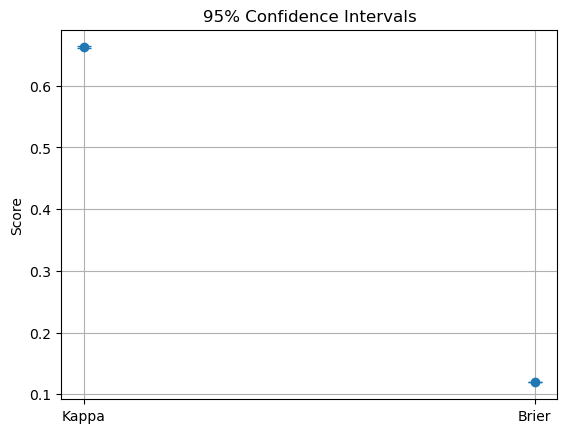

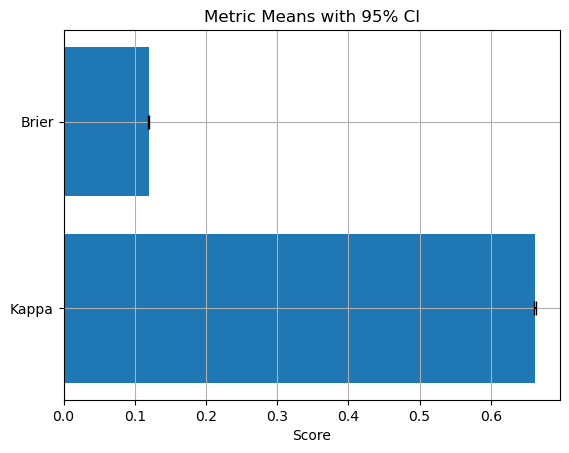

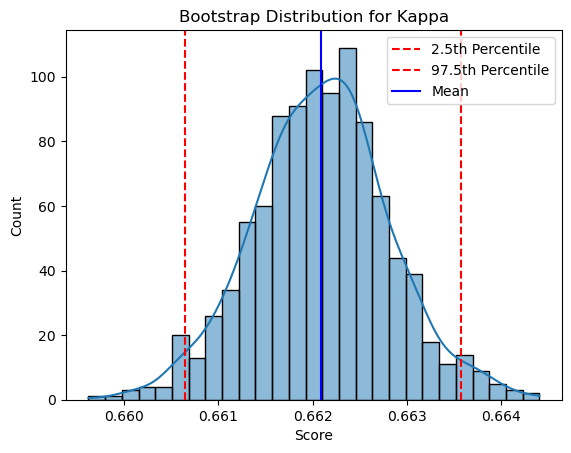

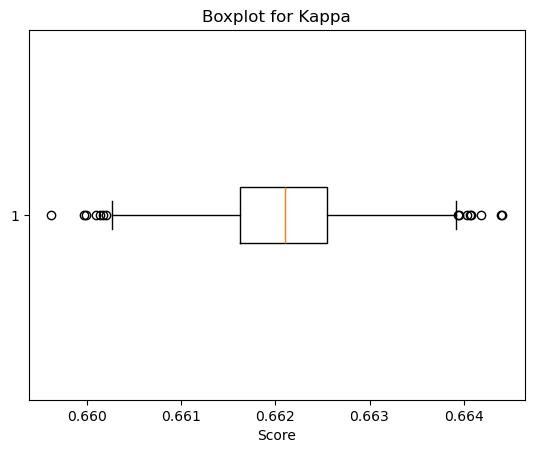

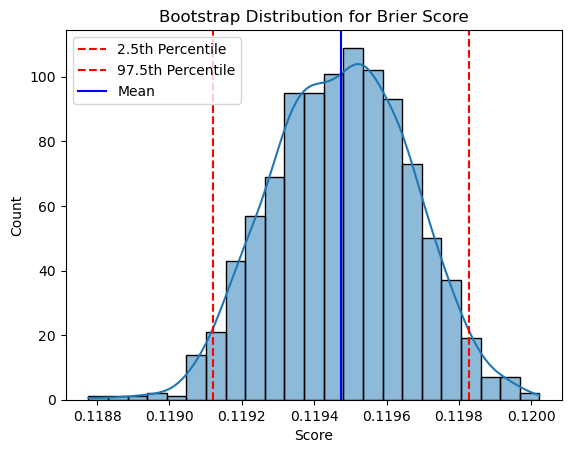

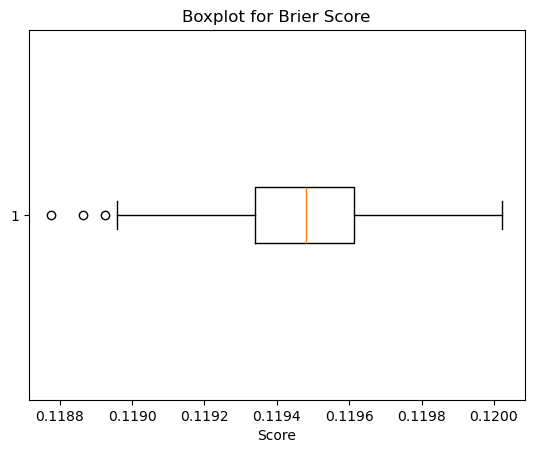


 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83    145790
           1       0.83      0.83      0.83    145790

    accuracy                           0.83    291580
   macro avg       0.83      0.83      0.83    291580
weighted avg       0.83      0.83      0.83    291580


Model 1 (Only ru/uk mapped page_titles) Metrics:
   Accuracy:                          0.7949
   AUC:                               0.8322
   F1 Score:                          0.8666
   Precision:                         0.8823
   Recall:                            0.8515
   Cohen’s Kappa:                     0.4242
   Brier Score:                       0.1358
   Brier Score (disagreements only): 0.4911
   Kappa 95% CI:                      [0.4108, 0.4374]
   Brier Score 95% CI:                [0.1333, 0.1383]


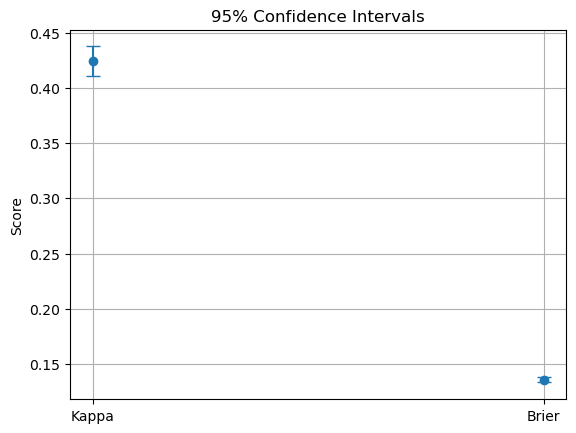

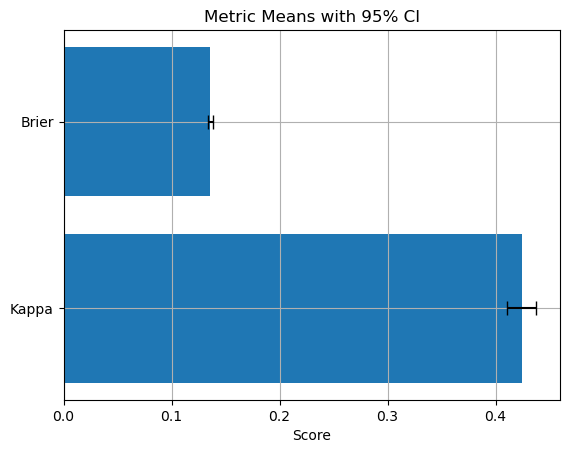

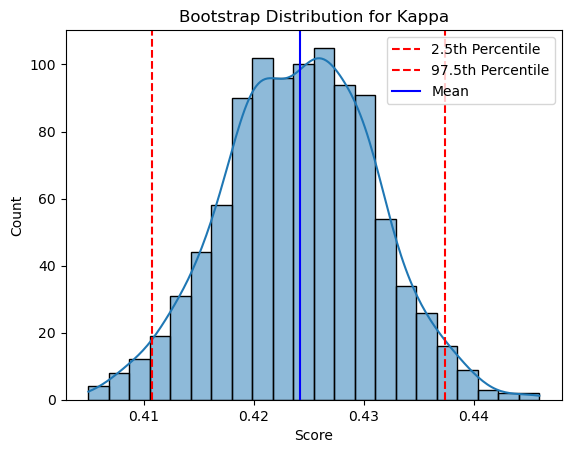

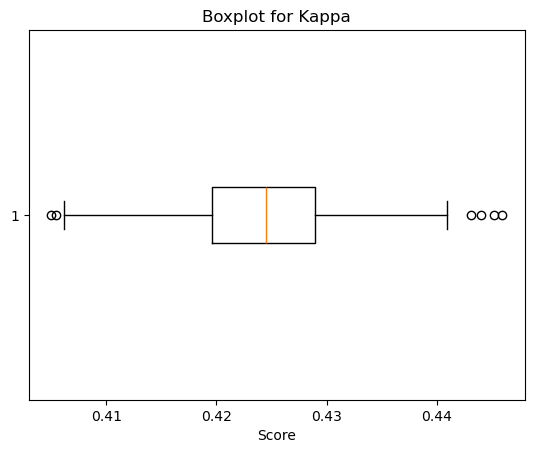

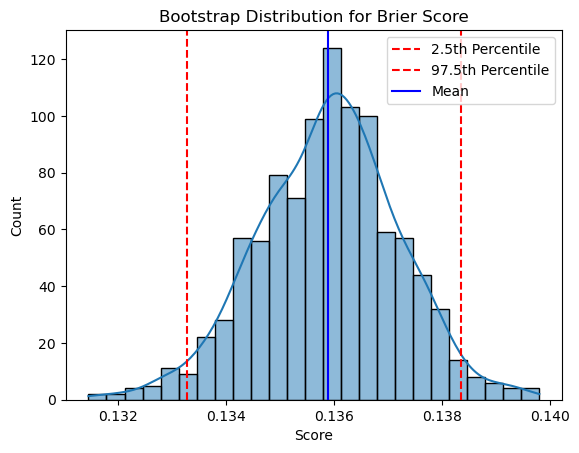

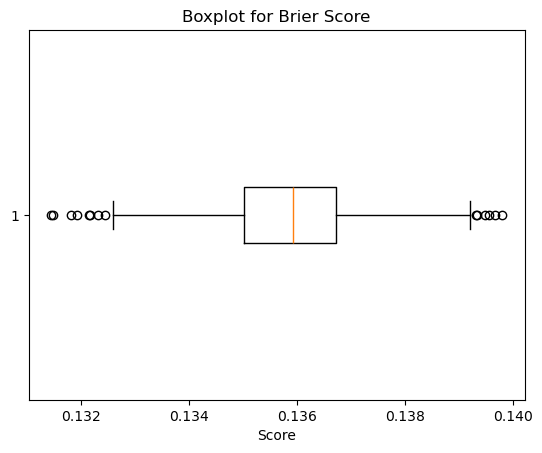


 Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.59      0.56      1387
           1       0.88      0.85      0.87      4982

    accuracy                           0.79      6369
   macro avg       0.70      0.72      0.71      6369
weighted avg       0.80      0.79      0.80      6369


Model 1 (Only UK Wikipedia) Metrics:
   Accuracy:                          0.8604
   AUC:                               0.9189
   F1 Score:                          0.7687
   Precision:                         0.8041
   Recall:                            0.7363
   Cohen’s Kappa:                     0.6690
   Brier Score:                       0.1005
   Brier Score (disagreements only): 0.5439
   Kappa 95% CI:                      [0.6659, 0.6722]
   Brier Score 95% CI:                [0.0997, 0.1014]


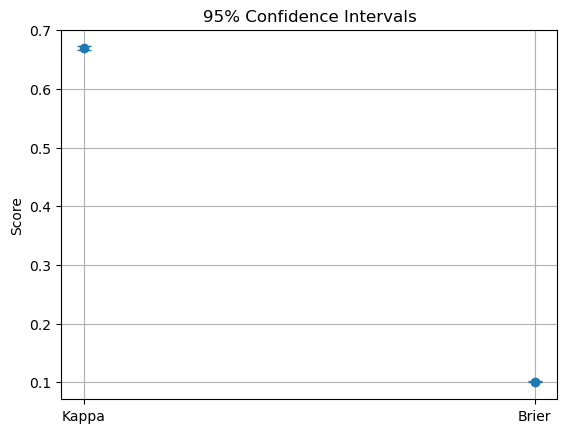

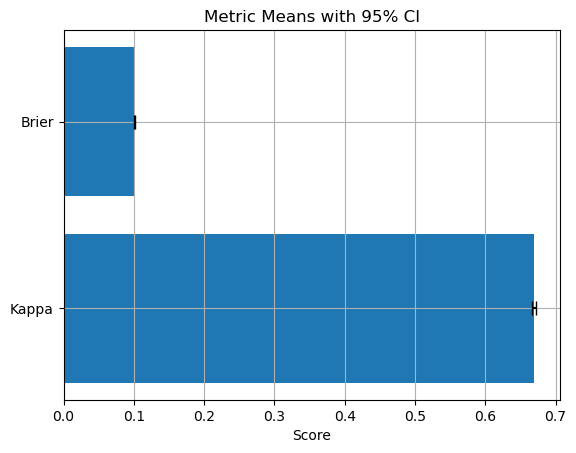

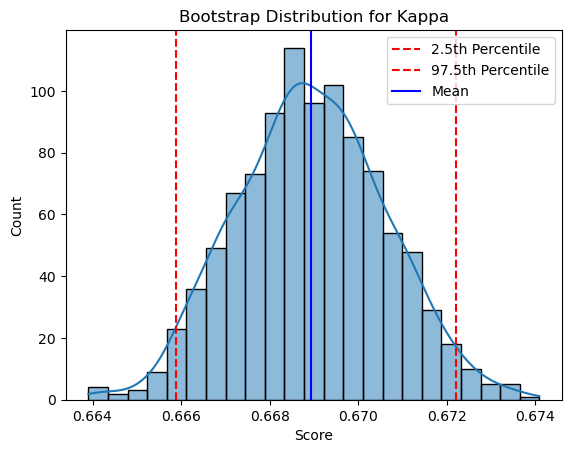

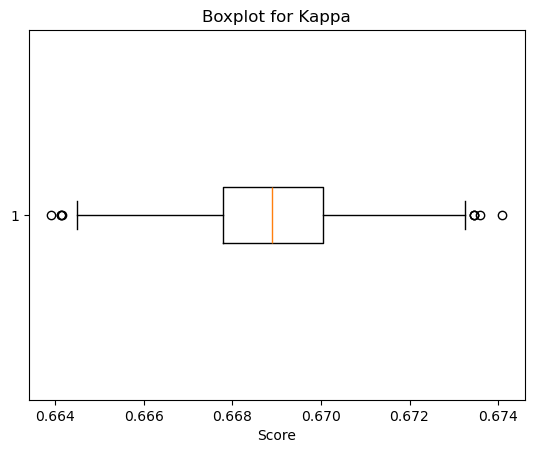

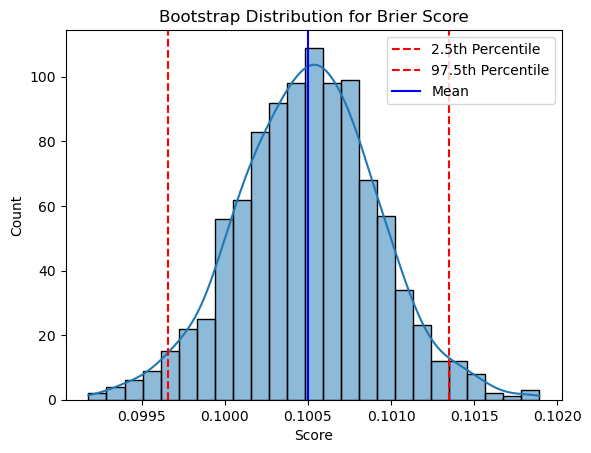

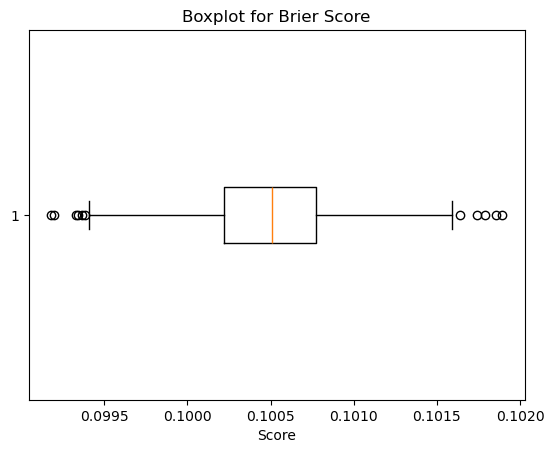


 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     39584
           1       0.80      0.74      0.77     18214

    accuracy                           0.86     57798
   macro avg       0.84      0.83      0.83     57798
weighted avg       0.86      0.86      0.86     57798


Model 1 (Only RU Wikipedia) Metrics:
   Accuracy:                          0.8238
   AUC:                               0.9031
   F1 Score:                          0.8396
   Precision:                         0.8344
   Recall:                            0.8448
   Cohen’s Kappa:                     0.6442
   Brier Score:                       0.1242
   Brier Score (disagreements only): 0.5121
   Kappa 95% CI:                      [0.6427, 0.6457]
   Brier Score 95% CI:                [0.1237, 0.1246]


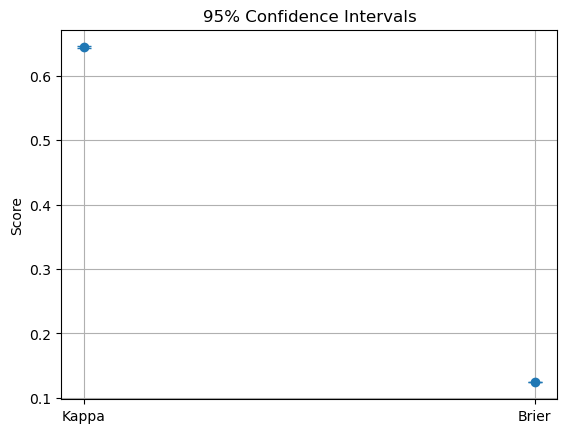

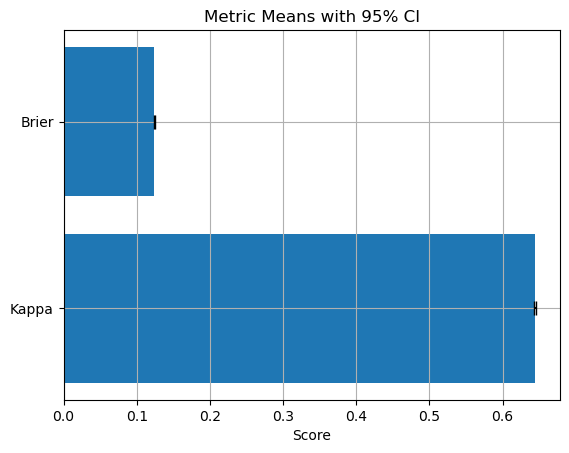

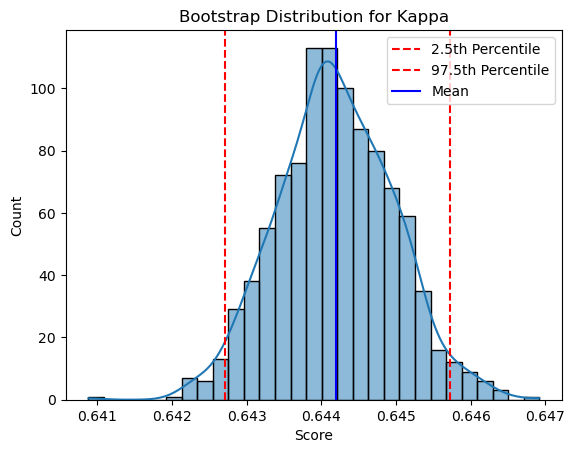

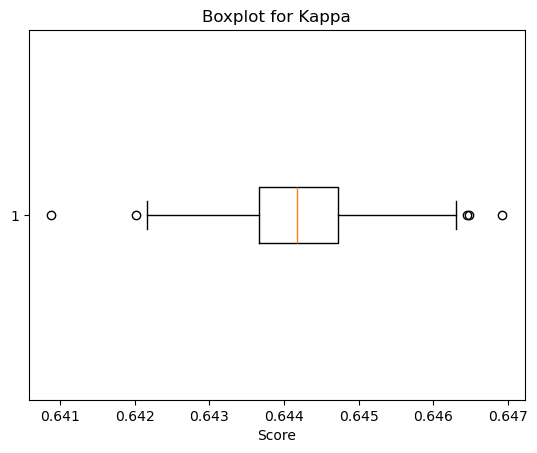

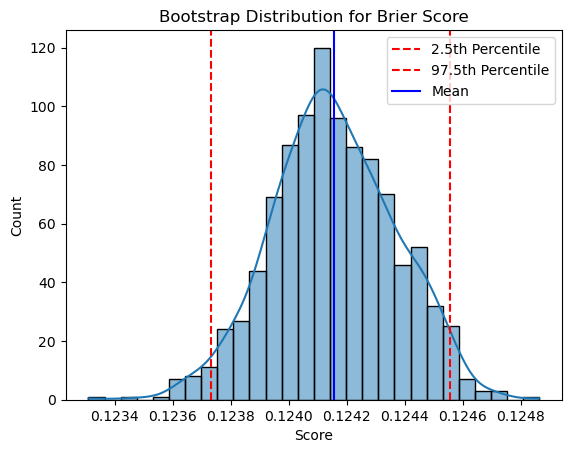

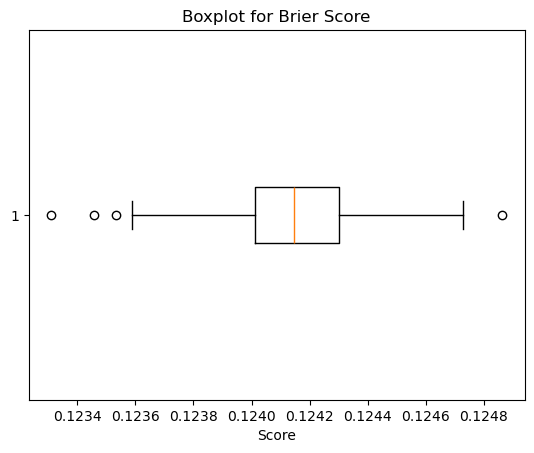


 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80    106206
           1       0.83      0.84      0.84    127576

    accuracy                           0.82    233782
   macro avg       0.82      0.82      0.82    233782
weighted avg       0.82      0.82      0.82    233782


Model 1 (Only UK Wikipedia (mapped ru/uk titles)) Metrics:
   Accuracy:                          0.7916
   AUC:                               0.8760
   F1 Score:                          0.8071
   Precision:                         0.8143
   Recall:                            0.8000
   Cohen’s Kappa:                     0.5806
   Brier Score:                       0.1442
   Brier Score (disagreements only): 0.5406
   Kappa 95% CI:                      [0.5592, 0.6032]
   Brier Score 95% CI:                [0.1373, 0.1505]


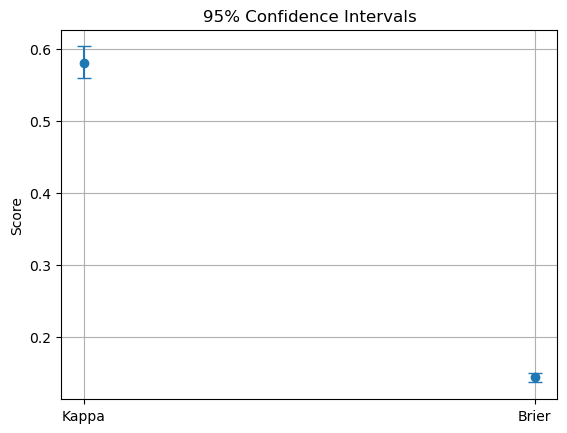

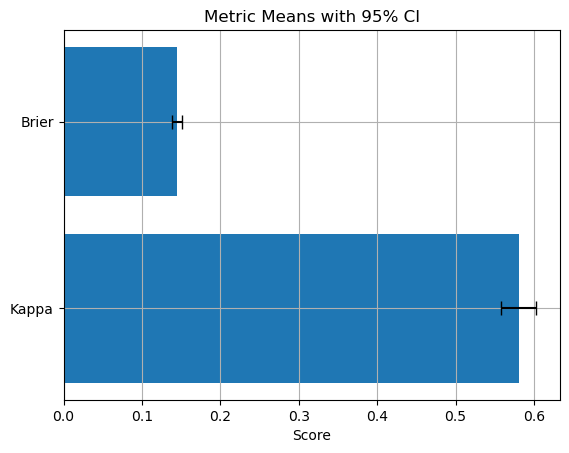

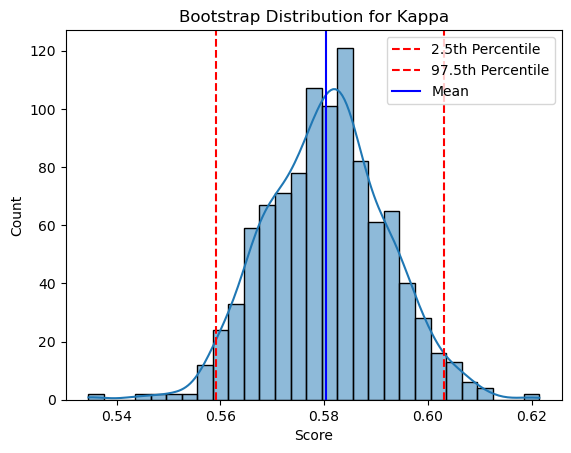

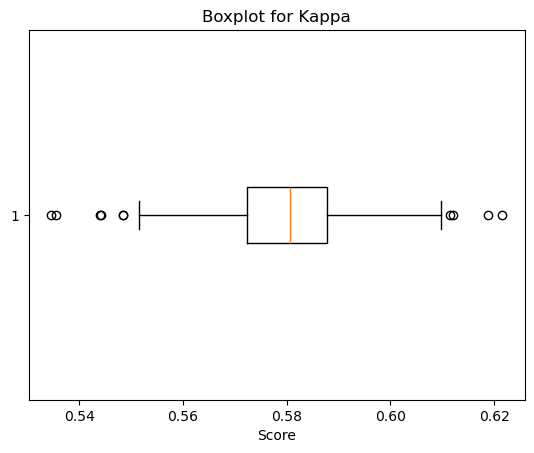

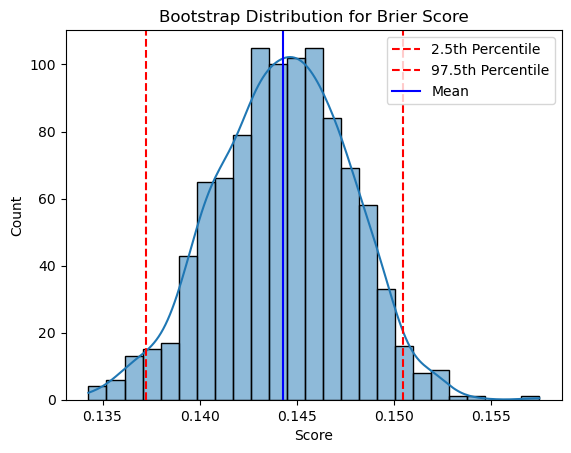

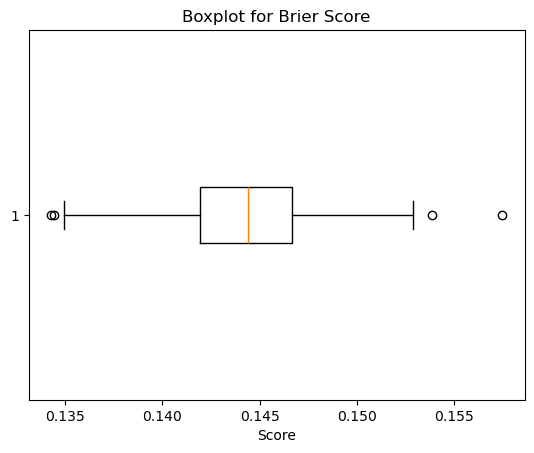


 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       522
           1       0.81      0.80      0.81       625

    accuracy                           0.79      1147
   macro avg       0.79      0.79      0.79      1147
weighted avg       0.79      0.79      0.79      1147


Model 1 (Only RU Wikipedia (mapped ru/uk titles)) Metrics:
   Accuracy:                          0.7957
   AUC:                               0.7930
   F1 Score:                          0.8752
   Precision:                         0.8922
   Recall:                            0.8588
   Cohen’s Kappa:                     0.3127
   Brier Score:                       0.1340
   Brier Score (disagreements only): 0.4800
   Kappa 95% CI:                      [0.2974, 0.3288]
   Brier Score 95% CI:                [0.1313, 0.1368]


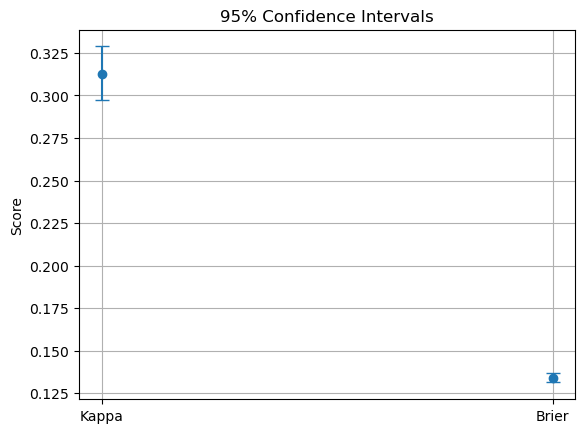

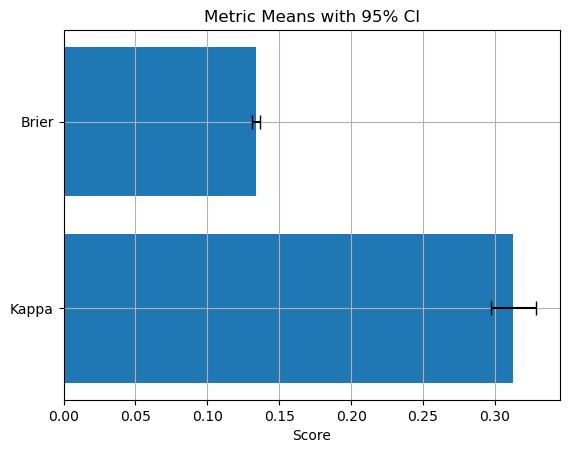

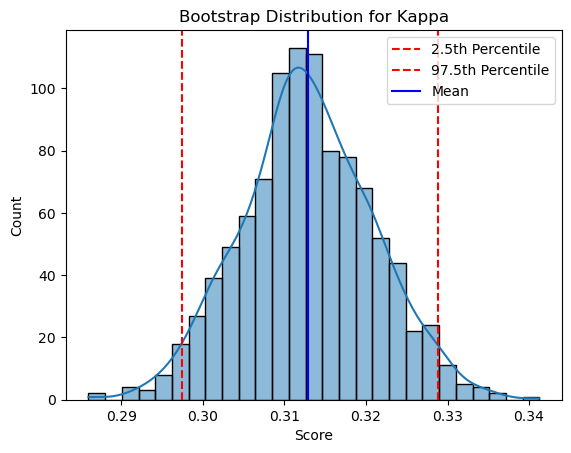

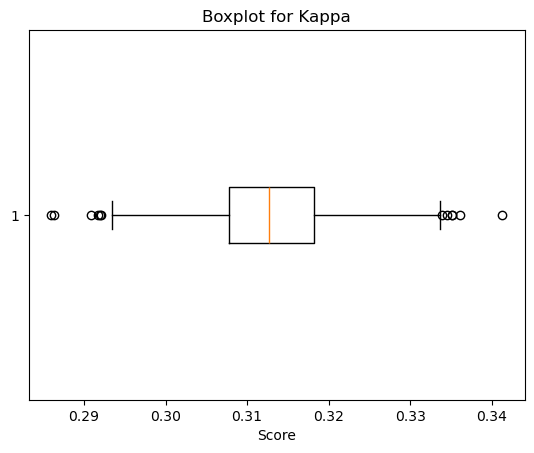

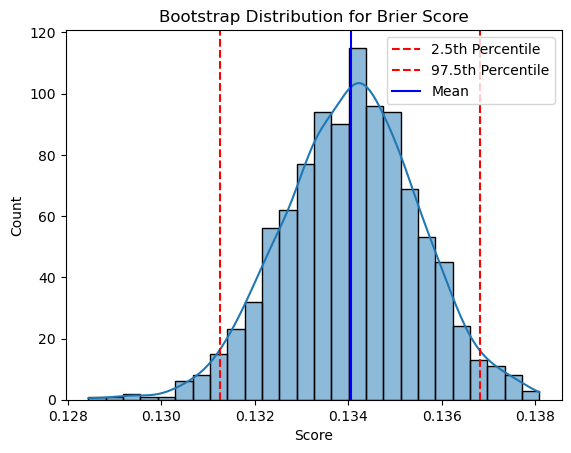

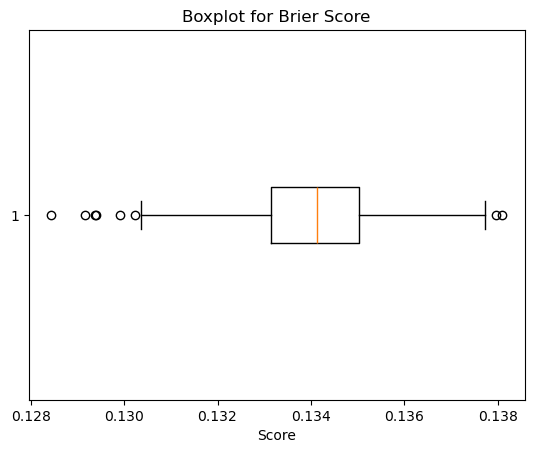


 Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.48      0.44       865
           1       0.89      0.86      0.88      4357

    accuracy                           0.80      5222
   macro avg       0.65      0.67      0.66      5222
weighted avg       0.81      0.80      0.80      5222


Model 2 (ALL) Metrics:
   Accuracy:                          0.8328
   AUC:                               0.9119
   F1 Score:                          0.8328
   Precision:                         0.8327
   Recall:                            0.8328
   Cohen’s Kappa:                     0.6656
   Brier Score:                       0.1186
   Brier Score (disagreements only): 0.5233
   Kappa 95% CI:                      [0.6642, 0.6668]
   Brier Score 95% CI:                [0.1182, 0.1189]


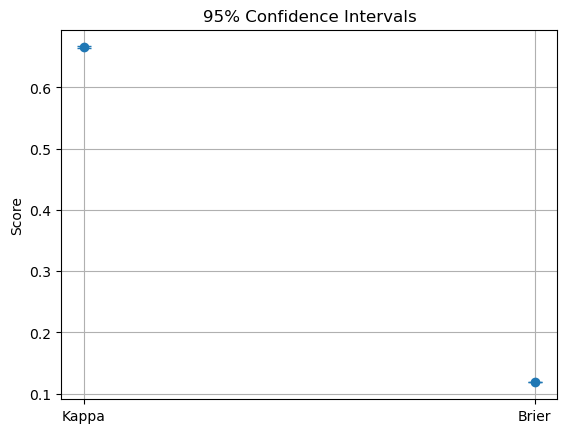

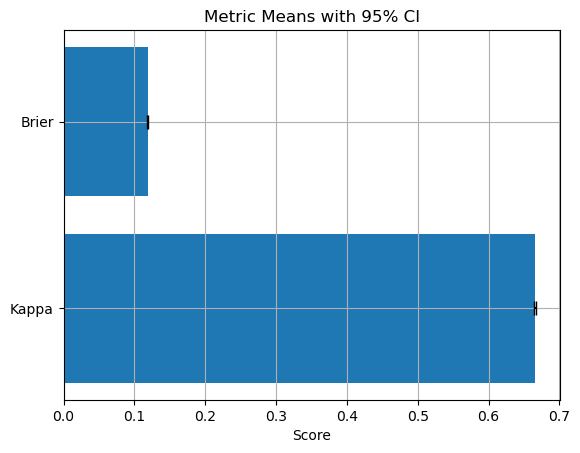

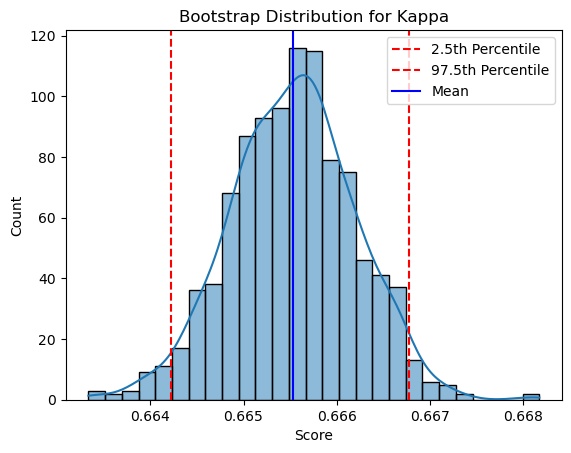

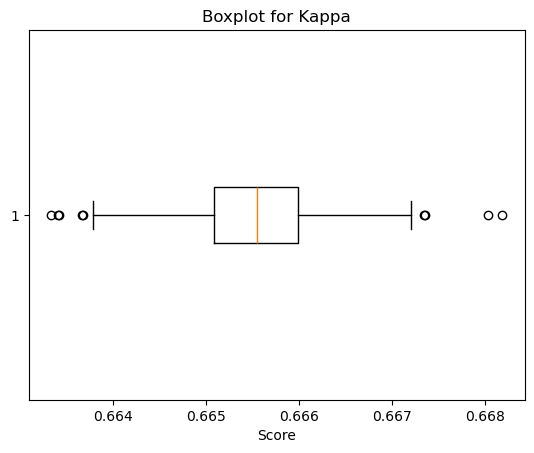

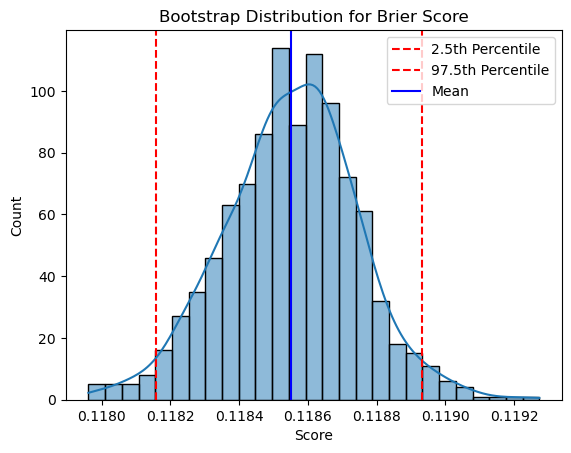

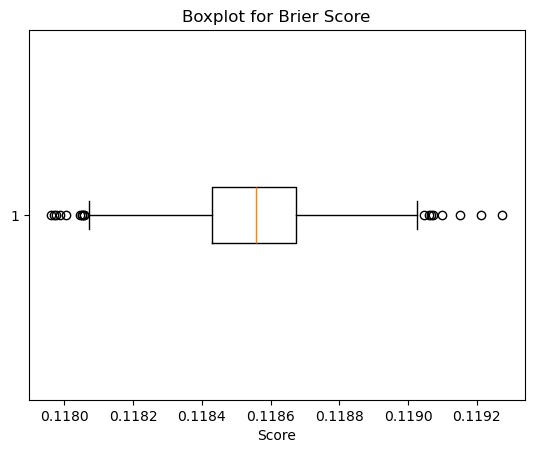


 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83    145790
           1       0.83      0.83      0.83    145790

    accuracy                           0.83    291580
   macro avg       0.83      0.83      0.83    291580
weighted avg       0.83      0.83      0.83    291580


Model 2 (Only ru/uk mapped page_titles) Metrics:
   Accuracy:                          0.8011
   AUC:                               0.8336
   F1 Score:                          0.8709
   Precision:                         0.8847
   Recall:                            0.8575
   Cohen’s Kappa:                     0.4385
   Brier Score:                       0.1357
   Brier Score (disagreements only): 0.5055
   Kappa 95% CI:                      [0.4248, 0.4517]
   Brier Score 95% CI:                [0.1330, 0.1380]


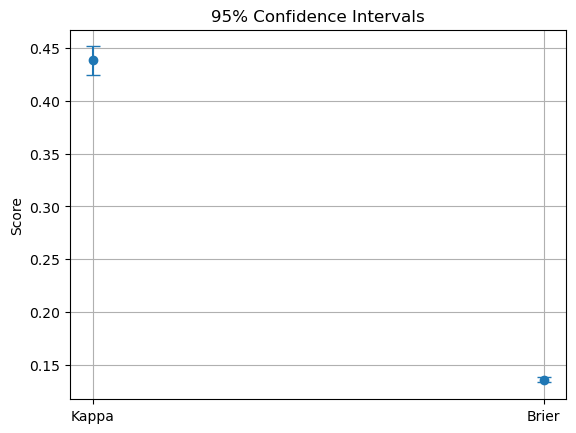

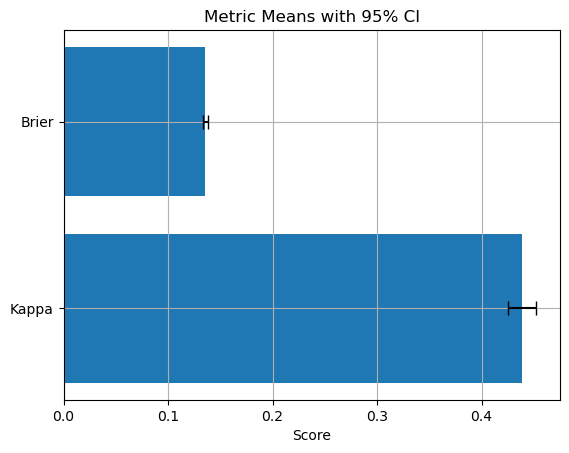

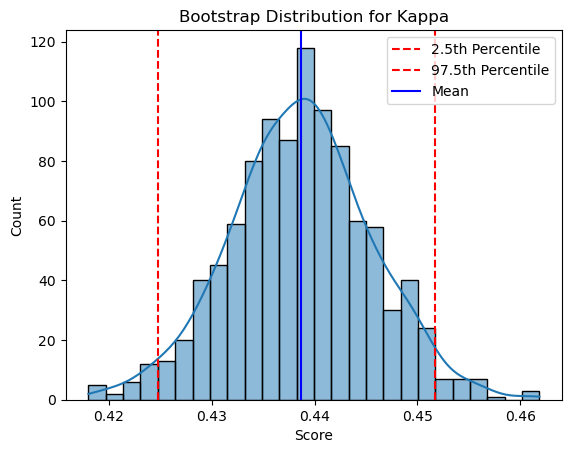

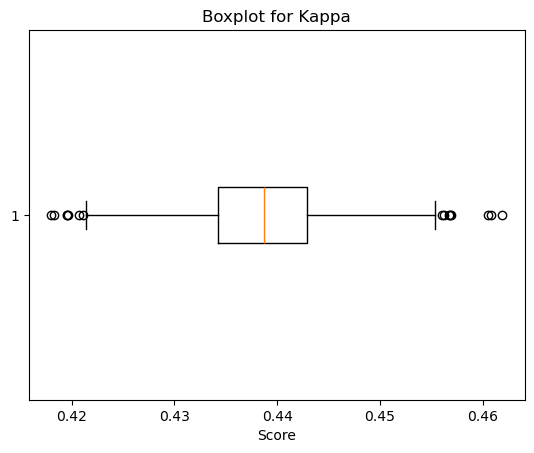

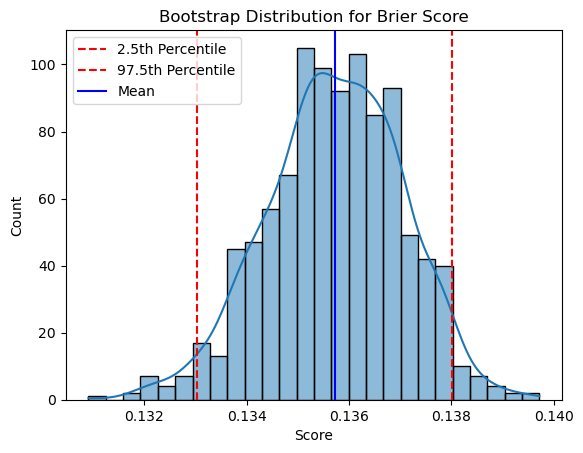

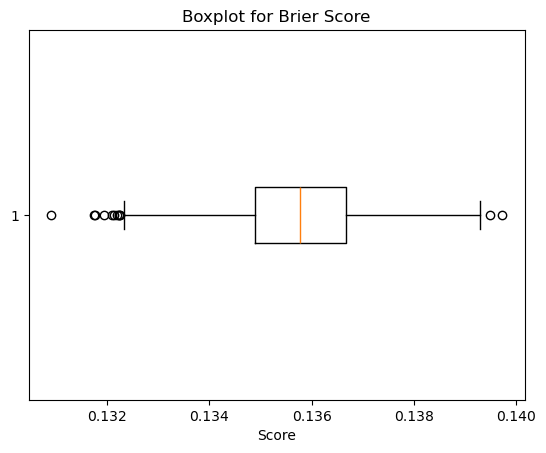


 Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.60      0.57      1387
           1       0.88      0.86      0.87      4982

    accuracy                           0.80      6369
   macro avg       0.71      0.73      0.72      6369
weighted avg       0.81      0.80      0.80      6369


Model 2 (Only UK Wikipedia) Metrics:
   Accuracy:                          0.8605
   AUC:                               0.9204
   F1 Score:                          0.7683
   Precision:                         0.8064
   Recall:                            0.7337
   Cohen’s Kappa:                     0.6689
   Brier Score:                       0.0996
   Brier Score (disagreements only): 0.5432
   Kappa 95% CI:                      [0.6658, 0.6721]
   Brier Score 95% CI:                [0.0988, 0.1004]


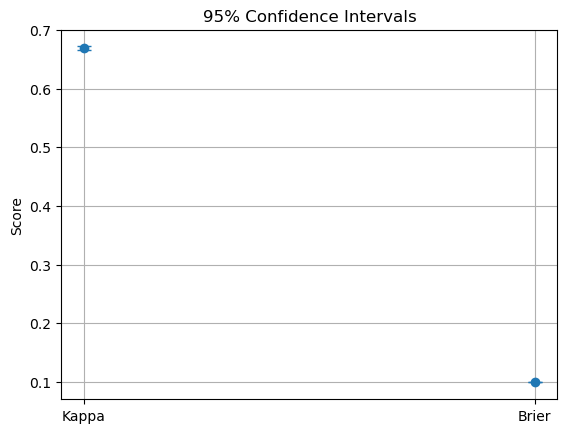

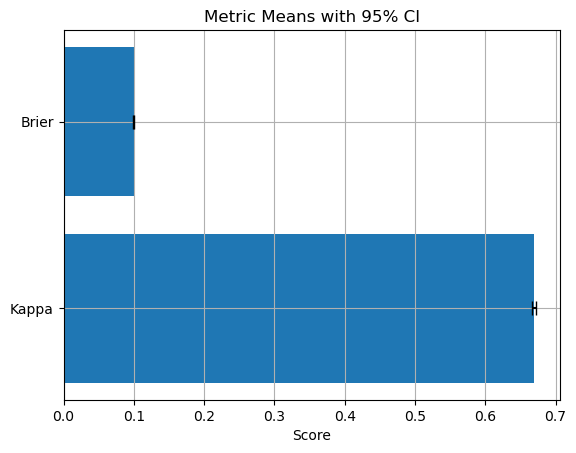

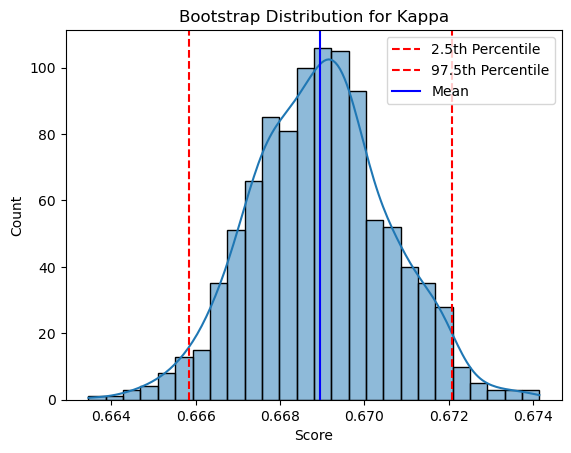

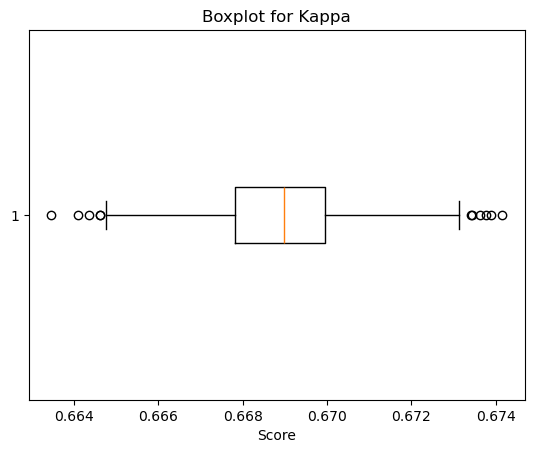

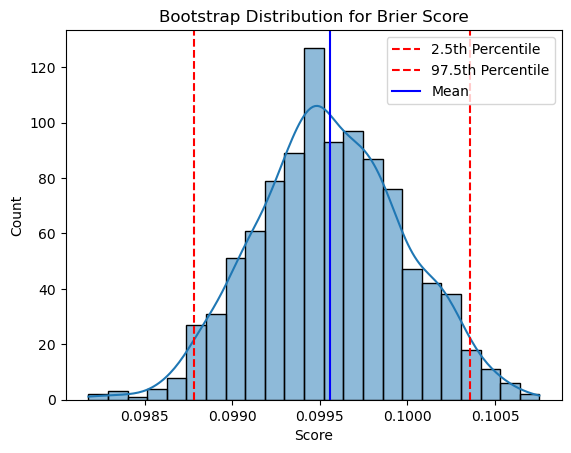

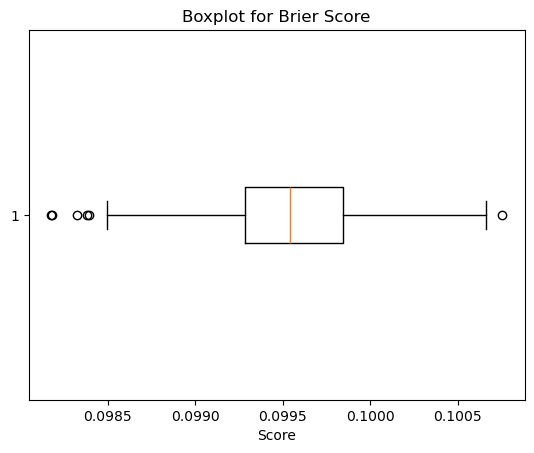


 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     39584
           1       0.81      0.73      0.77     18214

    accuracy                           0.86     57798
   macro avg       0.84      0.83      0.83     57798
weighted avg       0.86      0.86      0.86     57798


Model 2 (Only RU Wikipedia) Metrics:
   Accuracy:                          0.8259
   AUC:                               0.9043
   F1 Score:                          0.8415
   Precision:                         0.8361
   Recall:                            0.8470
   Cohen’s Kappa:                     0.6484
   Brier Score:                       0.1232
   Brier Score (disagreements only): 0.5194
   Kappa 95% CI:                      [0.6470, 0.6500]
   Brier Score 95% CI:                [0.1228, 0.1237]


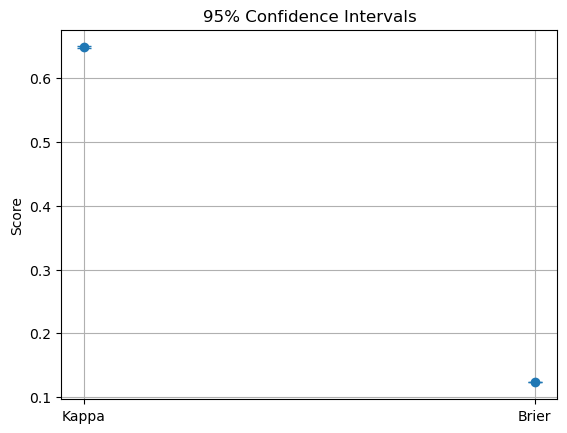

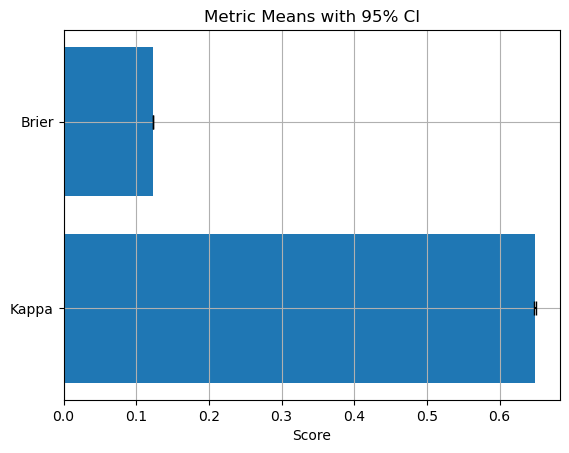

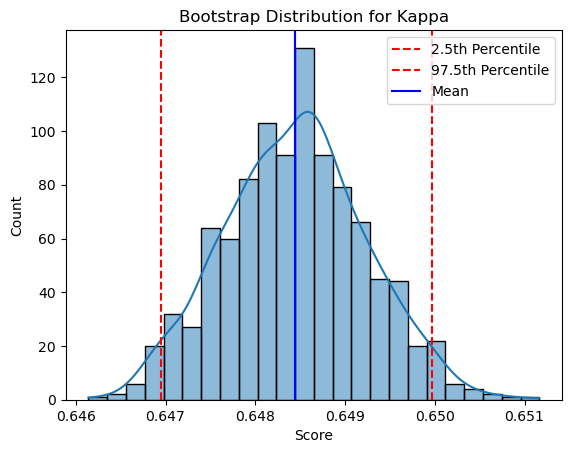

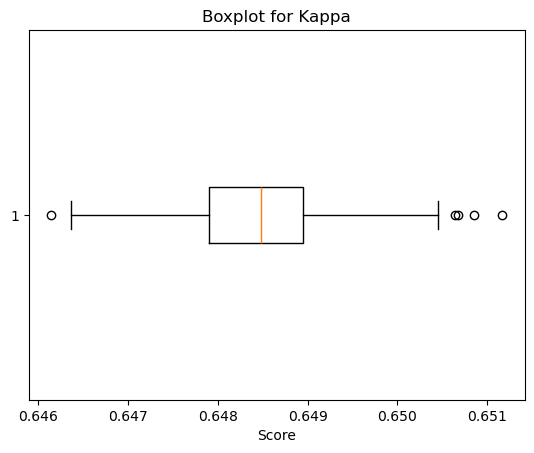

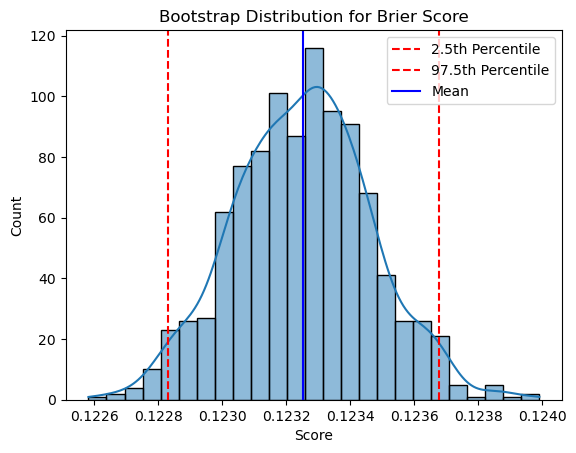

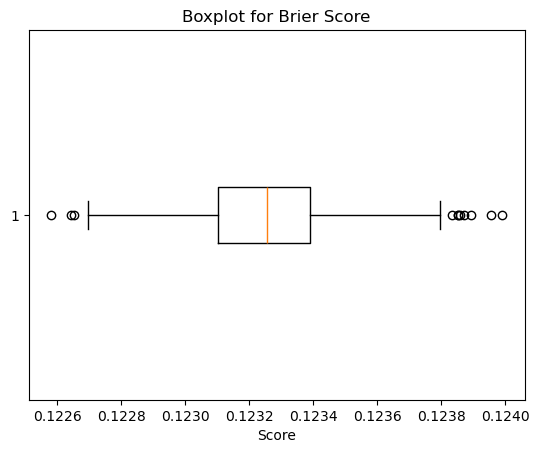


 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81    106206
           1       0.84      0.85      0.84    127576

    accuracy                           0.83    233782
   macro avg       0.82      0.82      0.82    233782
weighted avg       0.83      0.83      0.83    233782


Model 2 (Only UK Wikipedia (mapped ru/uk titles)) Metrics:
   Accuracy:                          0.7942
   AUC:                               0.8795
   F1 Score:                          0.8088
   Precision:                         0.8194
   Recall:                            0.7984
   Cohen’s Kappa:                     0.5862
   Brier Score:                       0.1415
   Brier Score (disagreements only): 0.5325
   Kappa 95% CI:                      [0.5624, 0.6090]
   Brier Score 95% CI:                [0.1351, 0.1476]


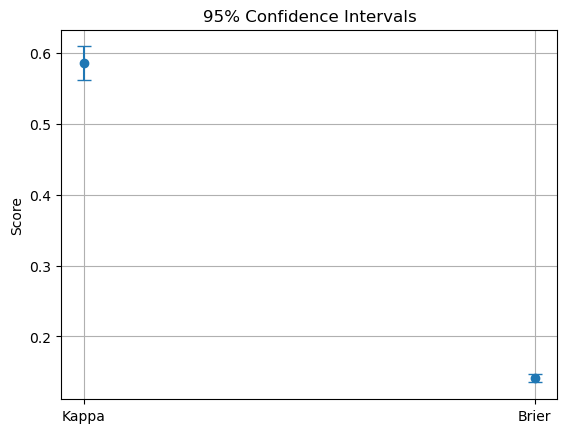

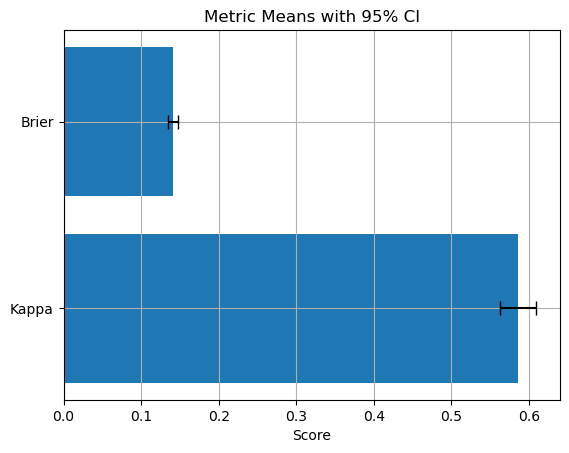

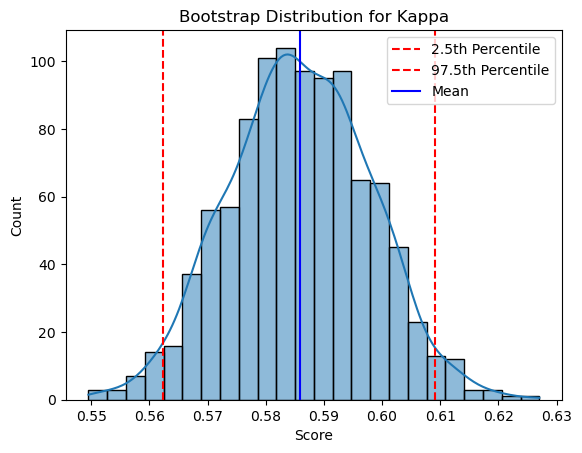

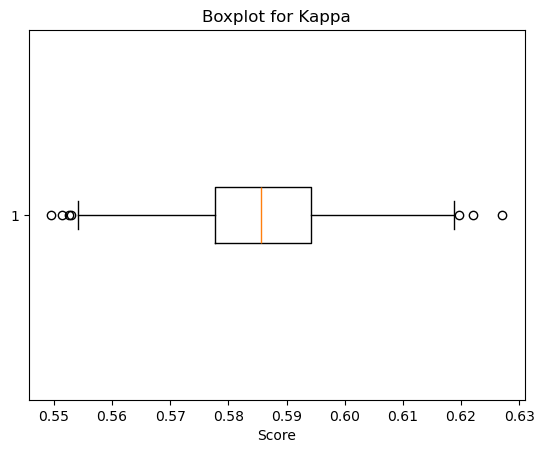

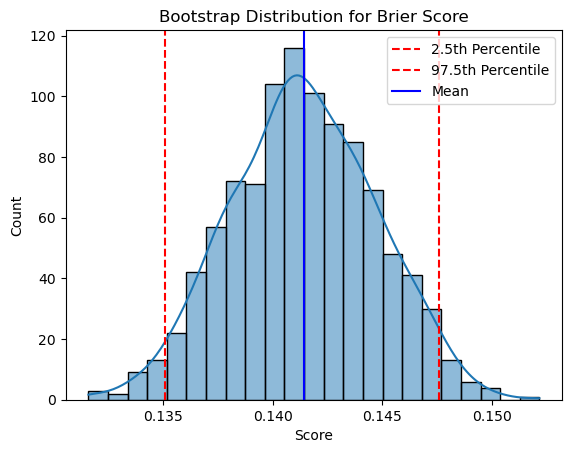

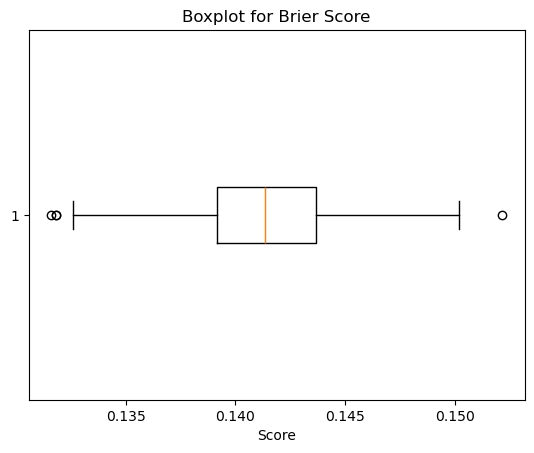


 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       522
           1       0.82      0.80      0.81       625

    accuracy                           0.79      1147
   macro avg       0.79      0.79      0.79      1147
weighted avg       0.79      0.79      0.79      1147


Model 2 (Only RU Wikipedia (mapped ru/uk titles)) Metrics:
   Accuracy:                          0.8026
   AUC:                               0.7937
   F1 Score:                          0.8798
   Precision:                         0.8941
   Recall:                            0.8660
   Cohen’s Kappa:                     0.3284
   Brier Score:                       0.1344
   Brier Score (disagreements only): 0.4994
   Kappa 95% CI:                      [0.3123, 0.3436]
   Brier Score 95% CI:                [0.1316, 0.1372]


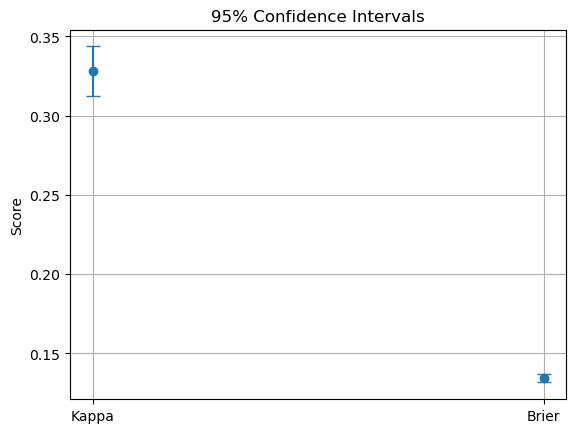

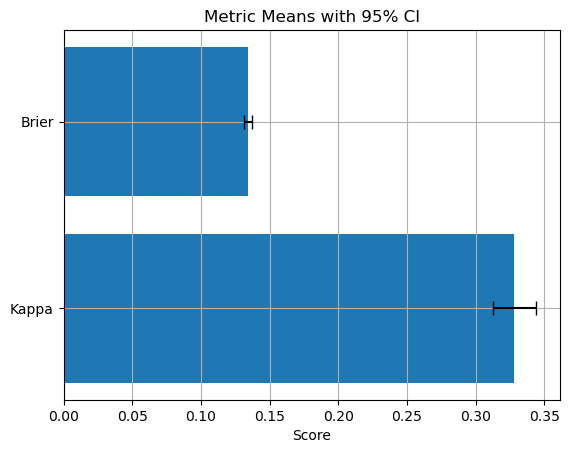

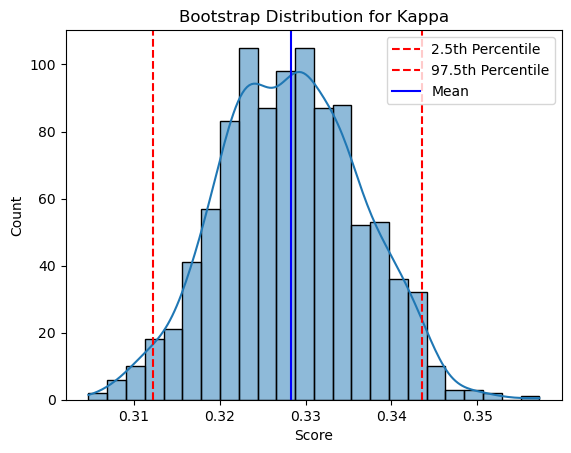

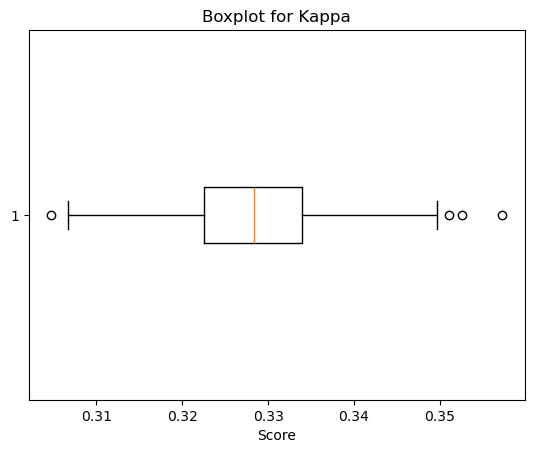

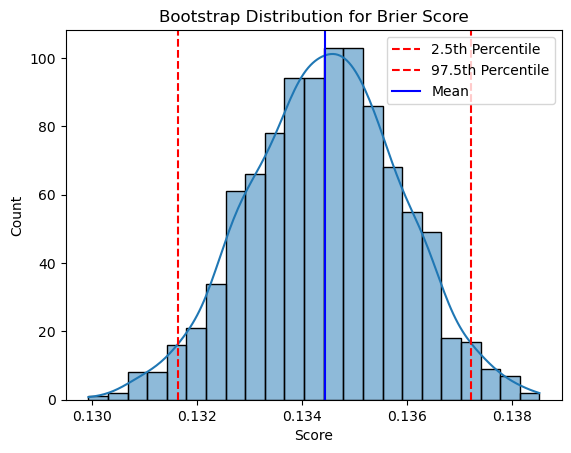

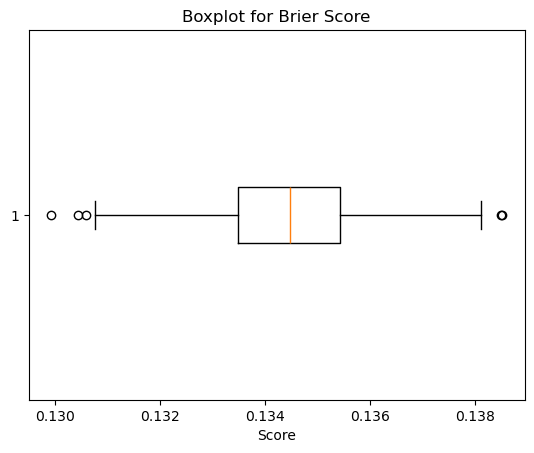


 Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.48      0.45       865
           1       0.89      0.87      0.88      4357

    accuracy                           0.80      5222
   macro avg       0.66      0.67      0.66      5222
weighted avg       0.82      0.80      0.81      5222



In [75]:
features_exp1 = base_features + vandalism_features + manipulation_features

X_test_eval = df.loc[X_test.index, features_exp1 + ['page_title']].copy()
X_test_eval[cat_features] = X_test_eval[cat_features].fillna("nan").astype(str)
y_test_eval = y.loc[X_test.index]
page_titles_test = X_test_eval['page_title']
X_test_clean = X_test_eval.drop(columns=['page_title'])

results_model1 = evaluate_model_on_subsets("Model 1", model1, X_test_clean, y_test_eval, page_titles_test, mapped_titles)
results_model2 = evaluate_model_on_subsets("Model 2", model2, X_test_clean, y_test_eval, page_titles_test, mapped_titles)